In [1]:
## 2.5 Parameter Fitting and Design Optimization

In [2]:
import numpy as np
from scipy.optimize import minimize
import cvxpy as cp
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.io import loadmat
from array import *

plt.rcParams['text.usetex'] = True

In [4]:
# Load data from .mat file
data = loadmat('Ex5Data.mat')
# Extract data from file
motor = data['motor'][0,0]
vehicle = data['vehicle'][0,0]
wltp3 = data['wltp3'][0,0]

# Only consider the positive torque section
T_m = motor['shaftTorque'][:, :29]
P_m = motor['shaftPower'][:, :29]
omega = motor['speed'][:, :29] * np.pi / 30
eta = motor['efficiency'][:, :29]

# Obtain the motor map for the positive torque section
P_loss = motor['totalLoss'][:, :29]

# Normalization constants
EbN = 1e8
PmN = 1e5
omegaN = 1e3

# Concatenate x vectors into X
##### Complete code here #####
X = np.vstack([np.ones(P_m.size), omega.flatten() / omegaN, P_m.flatten() / PmN])
##########

# Optimization variable
##### Complete code here #####
Q = cp.Variable((3, 3))
##########

# Define the objective function
P_loss_model = cp.sum(cp.multiply((Q @ X),  X), axis=0)

# Constraints
##### Complete code here #####
constraints = [
    Q >= 0,
    P_loss_model >= 0
]
##########

# Find best fit with least-error squared
objective = cp.norm(P_loss_model - (P_loss.flatten() / PmN))

problem = cp.Problem(cp.Minimize(objective), constraints)
problem.solve(solver=cp.MOSEK, verbose=True)
#options = sdpsettings(solver='mosek', verbose=2)
# optimize(constraints, objective, options)

print("solution =", Q.value)


                                     CVXPY                                     
                                     v1.5.3                                    
(CVXPY) Feb 19 11:25:45 AM: Your problem has 9 variables, 1140 constraints, and 0 parameters.
(CVXPY) Feb 19 11:25:45 AM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Feb 19 11:25:45 AM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Feb 19 11:25:45 AM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Feb 19 11:25:45 AM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Feb 19 11:25:45 AM: Compiling problem (target solver=MOSEK).
(

c:\Users\tychob\Projects\4DM20-engineering-optimization\ComputerAssignment2_python\.venv\Lib\site-packages\mosek\__init__.py:18617: UserWarning: Argument sub in putvarboundlist: Incorrect array format causing data to be copied
  warnings.warn("Argument sub in putvarboundlist: Incorrect array format causing data to be copied");
c:\Users\tychob\Projects\4DM20-engineering-optimization\ComputerAssignment2_python\.venv\Lib\site-packages\mosek\__init__.py:18925: UserWarning: Argument subj in putclist: Incorrect array format causing data to be copied
  warnings.warn("Argument subj in putclist: Incorrect array format causing data to be copied");
c:\Users\tychob\Projects\4DM20-engineering-optimization\ComputerAssignment2_python\.venv\Lib\site-packages\mosek\__init__.py:18349: UserWarning: Argument sub in putconboundlist: Incorrect array format causing data to be copied
  warnings.warn("Argument sub in putconboundlist: Incorrect array format causing data to be copied");


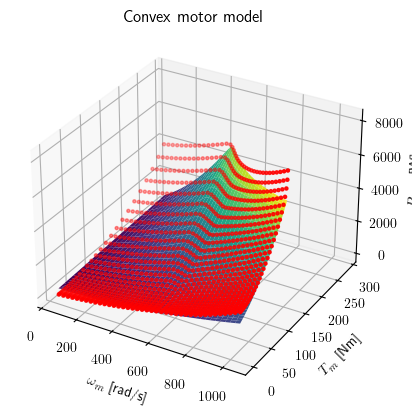

In [5]:
# Reshape and compute the modeled loss
P_loss_model_plot = P_loss_model.value * PmN
P_loss_model_arr = np.reshape(P_loss_model_plot, P_loss.shape)

# Plotting
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(omega, T_m, P_loss_model_arr, cmap='viridis')
ax.scatter(omega, T_m, P_loss, c='r', marker='.')
ax.set_xlabel(r'$\omega_m$ [rad/s]')
ax.set_ylabel(r'$T_m$ [Nm]')
ax.set_zlabel(r'$P_{loss}$ [W]')
ax.set_title('Convex motor model')
plt.show()

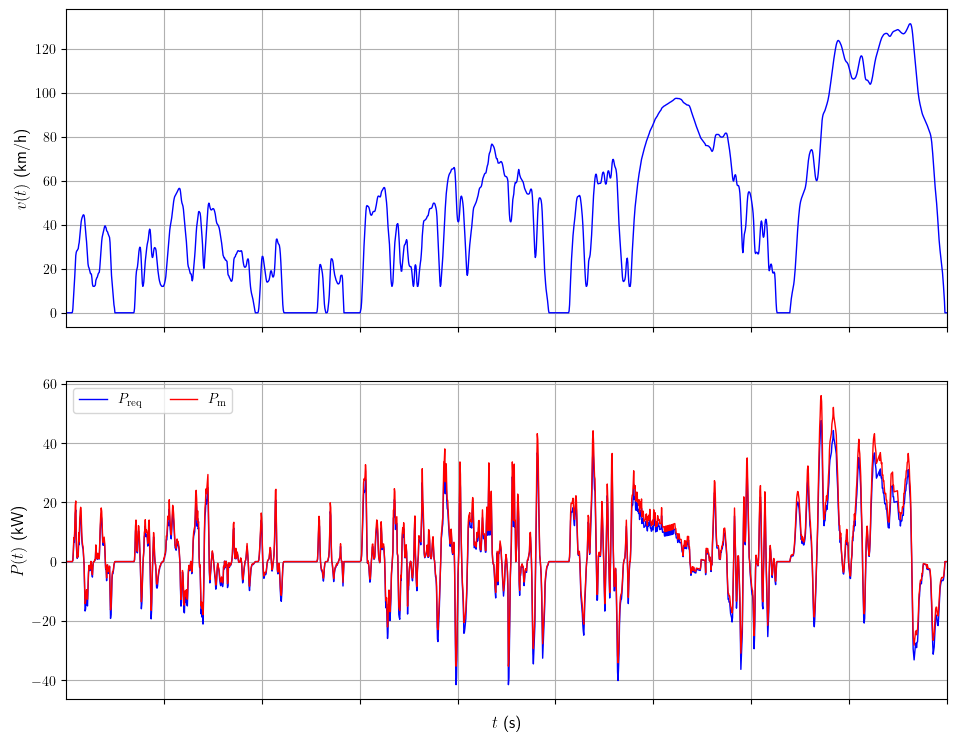

In [6]:
diff_velocity = np.diff(np.concatenate(([0], wltp3['velocity'].flatten())))

# Calculate requested power
##### Complete code here #####
P_req = vehicle['mass'][0,0] * diff_velocity * wltp3['velocity'].flatten() + 0.5 * vehicle['rho'][0,0] * vehicle['dragCoefficient'][0,0] * vehicle['frontalArea'][0,0] * wltp3['velocity'].flatten()**3
##########

# Calculate motor power depending on sign of requested power
P_m = np.where(P_req >= 0,
               P_req / vehicle['gearboxEfficiency'][0,0],
               P_req * vehicle['gearboxEfficiency'][0,0])

fig, axs = plt.subplots(2, 1, figsize=(10, 8), sharex=True)
fig.tight_layout(pad=3)

# --- Drive Cycle Velocity Profile ---
axs[0].plot(wltp3['time'], wltp3['velocity']*3.6, 'b', linewidth=1)
axs[0].grid(True)
axs[0].set_ylabel(r'$v(t)$ (km/h)', fontsize=12)
axs[0].set_xlim([1, wltp3['time'][-1]])
# Remove x-tick labels on the first plot
axs[0].set_xticklabels([])

# --- Requested Power at the Wheels ---
axs[1].plot(wltp3['time'], P_req/1e3, 'b', linewidth=1, label=r'$P_\mathrm{req}$')
axs[1].plot(wltp3['time'], P_m/1e3, 'r', linewidth=1, label=r'$P_\mathrm{m}$')
axs[1].grid(True)
axs[1].set_ylabel(r'$P(t)$ (kW)', fontsize=12)
axs[1].set_xlabel(r'$t$ (s)', fontsize=12)
axs[1].set_xlim([1, wltp3['time'][-1]])
axs[1].legend(loc='upper left', ncol=2)